# **Классификация звуков ESC-50**


Набор данных ESC-50 представляет собой набор WAV-файлов. Скачаем его, клонировав репозиторий Git:

In [1]:
!git clone https://github.com/karoldvl/ESC-50

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136 (from 1)
Receiving objects: 100% (4199/4199), 878.79 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


Все WAV-файлы хранятся в аудиокаталоге с именами файлов следующего формата:

`1-100032-A-0.wav`

Нам важно последнее число в имени файла, потому что оно говорит нам,
какому классу был присвоен этот файл звукозаписи. Другие части имени файла нам не важны, но в основном они связаны с набором данных
Freesound, из которого были взяты данные ESC-50.

In [2]:
import os
import random
import pandas as pd
import numpy as np
import IPython.display as display

In [3]:
# audio_files_path = '/content/ESC-50/audio/'
audio_files_path = '/kaggle/working/ESC-50/audio/'

audio_files_list = os.listdir(audio_files_path)

Мы можем загрузить метаинформацию о данных, по которым и увидем, что данные о классе объекта присутствует в названии файла.

In [4]:
meta_info = pd.read_csv('/kaggle/working/ESC-50/meta/esc50.csv')
print('Shape of data:', meta_info.shape)
meta_info.head()

Shape of data: (2000, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
# Создаем словарь из данных в колонках 'target' и 'category'
lbl2cat = meta_info.set_index('target')['category'].to_dict()
print(lbl2cat)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


Если мы хотим прослушать звук в ESC-50, то можем
использовать встроенный аудиопроигрыватель Jupyter, IPython.display.
Audio:

In [7]:
# Выбираем случайный индекс
random_idx = random.randint(0, len(audio_files_list) - 1)
print('audio file name:', audio_files_list[random_idx])
print(
    'object class:   ',
    lbl2cat[int(audio_files_list[random_idx].split('.')[0].split('-')[-1])]
)
display.Audio(audio_files_path + audio_files_list[random_idx])

audio file name: 4-175000-A-40.wav
object class:    helicopter


## Исследование данных

Мы знаем, что последний набор цифр в каждом имени файла описывает
класс, к которому он принадлежит, поэтому нам нужно получить список
файлов и подсчитать наличие каждого класса:

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

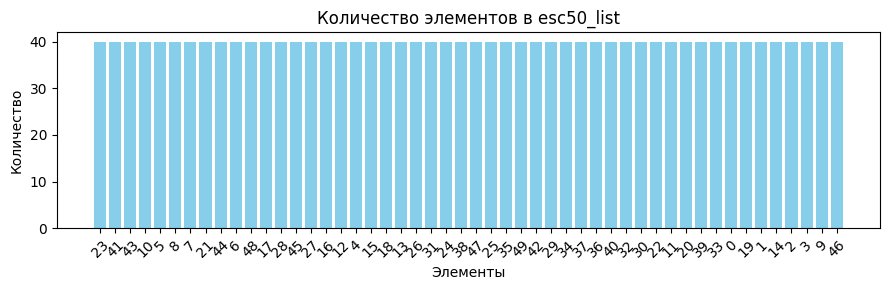

In [9]:
# Создаем список esc50_list
esc50_list = [f.split("-")[-1].replace(".wav", "") for f in audio_files_list]

# Считаем количество каждого элемента
counter = Counter(esc50_list)

# Получаем данные для визуализации
labels = list(counter.keys())
values = list(counter.values())

# Создаем график
plt.figure(figsize=(9, 3))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Элементы')
plt.ylabel('Количество')
plt.title('Количество элементов в esc50_list')
plt.xticks(rotation=45)
plt.tight_layout()  # Чтобы избежать наложения меток
plt.show()

Это тот редкий случай, когда набор данных идеально сбалансирован.

Установим еще несколько библиотек, которые
понадобятся в ближайшее время.

## SoX и LibROSA

Большая часть обработки аудиоданных, которую выполняет torchaudio,
основана на двух других видах программного обеспечения: SoX и LibROSA.

LibROSA — это библиотека Python для аудиоанализа, включающая генерацию мел-спектрограмм, обнаружение
ритмов и даже создание музыки.

SoX — это программа для преобразования WAV-файлов в формат MP3.

In [9]:
# !pip install sox -q

In [10]:
# import sox
import torchaudio
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import torchvision
import librosa
import librosa.display
from PIL import Image
from tqdm import tqdm

## ESC-50 Dataset & DataLoaders

В пользовательском наборе данных должны быть реализованы два метода класса `__getitem__` и `__len__`, чтобы загрузчик данных мог получить пакет тензоров и их маркировки, а также общее количество тензоров в наборе данных. У нас также есть метод `__init__` для настройки пути к файлам, которые будут неоднократно использоваться.

In [11]:
class ESC50(Dataset):
    def __init__(self, path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))
    def __len__(self):
        return self.length

Нам нужно создать выборки для обучения, валидации и для тестов. На данный момент у нас есть только один каталог со всеми данными. Разделение данных в пропорции 60/20/20 на обучающие, валидационные и тестовые соответствует нашим целям. Итак, мы можем это сделать, взяв случайную выборку из всего набора данных (обеспечив выборку без замены и убедившись, что только что созданные наборы данных сбалансированы), но опять же, набор данных ESC-50 избавляет нас от необходимости выполнять большую работу. Компиляторы набора данных разделили данные на пять равных сбалансированных фолдов, обозначенных первой цифрой в имени файла. У нас будут фолды 1, 2, 3 — набор данных для обучения, 4 — набор данных для валидации и 5 — набор данных для теста. Переместим каждый фолд в каталоги тестирования, обучения и валидации, предварительно создав соответствующие папки:

In [12]:
# !mkdir -p /content/train /content/valid /content/test
# !mv /content/ESC-50/audio/1* /content/train/
# !mv /content/ESC-50/audio/2* /content/train/
# !mv /content/ESC-50/audio/3* /content/train/
# !mv /content/ESC-50/audio/4* /content/valid/
# !mv /content/ESC-50/audio/5* /content/test/

!mkdir -p /kaggle/working/train /kaggle/working/valid
!mv /kaggle/working/ESC-50/audio/1* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/2* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/3* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/4* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/5* /kaggle/working/valid/

Теперь мы можем создавать отдельные наборы данных и загрузчики:

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bs = 64
PATH_TO_ESC50 = Path.cwd() / 'esc50'

# train_esc50 = ESC50("/content/train")
# valid_esc50 = ESC50("/content/valid")
# test_esc50  = ESC50("/content/test")

train_esc50 = ESC50('/kaggle/working/train')
valid_esc50 = ESC50("/kaggle/working/valid")
# test_esc50  = ESC50("/kaggle/working/test")

train_loader = DataLoader(
    dataset=train_esc50,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
    )

valid_loader = DataLoader(
    dataset=valid_esc50,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
    )

# test_loader  = DataLoader(
#     dataset=test_esc50,
#     batch_size=bs,
#     num_workers=os.cpu_count(),
#     shuffle=False,
#     pin_memory=True
#     )

Данные готовы, займемся моделированием.

## AudioNet

Для первой попытки классификации звуков мы создадим простую CNN-модель, которая в значительной степени будет построена на базе статьи под названием [Very Deep Convolutional Networks For Raw Waveforms](https://arxiv.org/pdf/1610.00087).

In [14]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(1)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

Также нужен оптимизатор и функция потерь.

In [30]:
audionet = AudioNet()
audionet.to(device)
learning_rate = 1e-4
optimizer = optim.Adam(audionet.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
criterion = nn.CrossEntropyLoss()

In [15]:
def train(model, optimizer, loss_fn, train_loader,
          val_loader, epochs=20, device=device, rep_freq=100, n_rounds=4):
    best_metric = torch.tensor(-9999)
    best_loss = 99999999
    k = 0
    iters = len(train_loader)
    
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    
    for epoch in range(1, epochs+1):
        epoch_train_loss = 0.0
        epoch_valid_loss = 0.0
        is_early_stopping = False
        model.train()
        train_num_correct = 0
        train_num_examples = 0
        for iteration, batch in enumerate(tqdm(train_loader, desc="Training")):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + iteration / iters)
            
            correct = torch.eq(
                torch.max(
                    F.softmax(output, dim=1), dim=1)[1],
                targets
            ).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]
            
            if rep_freq is not None:
                if ((iteration+1) % rep_freq == 0) or (iteration == 0):
                    print("===> Epoch[{}]({}/{}): "
                        "Loss: {:.6f}".format(
                            epoch, iteration+1, len(train_loader), loss.item()
                        ))

        # Считаем среднюю ошибку за эпоху
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        avg_train_accuracy = train_num_correct / train_num_examples
        train_acc_history.append(avg_train_accuracy)
        
        print("===> Epoch {} Complete: "
            "Avg. Loss: {:.4f}".format(epoch, avg_train_loss)
             )
        print(f"===> Avg. Accuracy: {avg_train_accuracy:.4f}")

        model.eval()
        valid_num_correct = 0
        valid_num_examples = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets)
                epoch_valid_loss += loss.data.item()
                correct = torch.eq(
                    torch.max(
                        F.softmax(output, dim=1), dim=1)[1],
                    targets
                ).view(-1)
                valid_num_correct += torch.sum(correct).item()
                valid_num_examples += correct.shape[0]
            
        # Считаем среднюю ошибку за эпоху
        avg_valid_loss = epoch_valid_loss / len(val_loader)
        valid_loss_history.append(avg_valid_loss)
        avg_valid_accuracy = valid_num_correct / valid_num_examples
        valid_acc_history.append(avg_valid_accuracy)
        
        if avg_valid_accuracy > best_metric:
            torch.save(model.state_dict(), "best.pt")
            best_metric = avg_valid_accuracy
            
        if best_loss > round(avg_valid_loss, 6):
            best_loss = round(avg_valid_loss, 6)
            k = 0
        elif k == n_rounds:
            is_early_stopping = True
        else:
            k += 1    
        
        print(f"===> Avg. Loss: {avg_valid_loss:.4f}"
             )
        print(f"===> Avg. Accuracy: {avg_valid_accuracy:.4f}")
        
        torch.save(model.state_dict(), "last.pt")
        
        if is_early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break

    return (
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
    )

In [26]:
print('Number of packages in the train_loader:', len(train_loader))
print('Number of packages in the valid_loader:', len(valid_loader))
# print('Number of packages in the test_loader: ', len(test_loader))

Number of packages in the train_loader: 25
Number of packages in the valid_loader: 7


In [32]:
tr_loss_hist, vl_loss_hist, tr_acc_hist, vl_acc_hist = train(
    audionet, optimizer, criterion,
    train_loader, valid_loader, epochs=30, rep_freq=None
)

Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


===> Epoch 1 Complete: Avg. Loss: 3.8578
===> Avg. Accuracy: 0.0387


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


===> Avg. Loss: 3.9112
===> Avg. Accuracy: 0.0225


Training: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


===> Epoch 2 Complete: Avg. Loss: 3.4611
===> Avg. Accuracy: 0.1537


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


===> Avg. Loss: 3.7055
===> Avg. Accuracy: 0.0625


Training: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


===> Epoch 3 Complete: Avg. Loss: 3.2227
===> Avg. Accuracy: 0.2537


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


===> Avg. Loss: 3.5862
===> Avg. Accuracy: 0.0875


Training: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


===> Epoch 4 Complete: Avg. Loss: 3.0294
===> Avg. Accuracy: 0.3488


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


===> Avg. Loss: 3.5275
===> Avg. Accuracy: 0.0950


Training: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


===> Epoch 5 Complete: Avg. Loss: 2.8871
===> Avg. Accuracy: 0.4150


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


===> Avg. Loss: 3.5081
===> Avg. Accuracy: 0.0925


Training: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


===> Epoch 6 Complete: Avg. Loss: 2.7815
===> Avg. Accuracy: 0.4575


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


===> Avg. Loss: 3.4898
===> Avg. Accuracy: 0.0950


Training: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


===> Epoch 7 Complete: Avg. Loss: 2.7152
===> Avg. Accuracy: 0.4819


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


===> Avg. Loss: 3.4872
===> Avg. Accuracy: 0.1000


Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


===> Epoch 8 Complete: Avg. Loss: 2.6811
===> Avg. Accuracy: 0.4944


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


===> Avg. Loss: 3.4820
===> Avg. Accuracy: 0.1000


Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


===> Epoch 9 Complete: Avg. Loss: 2.6705
===> Avg. Accuracy: 0.4919


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


===> Avg. Loss: 3.4796
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


===> Epoch 10 Complete: Avg. Loss: 2.6503
===> Avg. Accuracy: 0.4975


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


===> Avg. Loss: 3.4394
===> Avg. Accuracy: 0.0975


Training: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


===> Epoch 11 Complete: Avg. Loss: 2.4786
===> Avg. Accuracy: 0.5344


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


===> Avg. Loss: 3.4166
===> Avg. Accuracy: 0.1175


Training: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


===> Epoch 12 Complete: Avg. Loss: 2.3186
===> Avg. Accuracy: 0.5881


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


===> Avg. Loss: 3.3816
===> Avg. Accuracy: 0.1250


Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


===> Epoch 13 Complete: Avg. Loss: 2.1928
===> Avg. Accuracy: 0.6150


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


===> Avg. Loss: 3.3653
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


===> Epoch 14 Complete: Avg. Loss: 2.0886
===> Avg. Accuracy: 0.6388


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


===> Avg. Loss: 3.3467
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


===> Epoch 15 Complete: Avg. Loss: 2.0124
===> Avg. Accuracy: 0.6613


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


===> Avg. Loss: 3.3477
===> Avg. Accuracy: 0.1175


Training: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


===> Epoch 16 Complete: Avg. Loss: 1.9577
===> Avg. Accuracy: 0.6681


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


===> Avg. Loss: 3.3252
===> Avg. Accuracy: 0.1200


Training: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


===> Epoch 17 Complete: Avg. Loss: 1.9283
===> Avg. Accuracy: 0.6756


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


===> Avg. Loss: 3.3226
===> Avg. Accuracy: 0.1225


Training: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


===> Epoch 18 Complete: Avg. Loss: 1.9003
===> Avg. Accuracy: 0.6887


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


===> Avg. Loss: 3.3234
===> Avg. Accuracy: 0.1300


Training: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


===> Epoch 19 Complete: Avg. Loss: 1.8960
===> Avg. Accuracy: 0.6925


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


===> Avg. Loss: 3.3239
===> Avg. Accuracy: 0.1325


Training: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


===> Epoch 20 Complete: Avg. Loss: 1.9070
===> Avg. Accuracy: 0.6787


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


===> Avg. Loss: 3.3158
===> Avg. Accuracy: 0.1225


Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


===> Epoch 21 Complete: Avg. Loss: 1.8218
===> Avg. Accuracy: 0.6837


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


===> Avg. Loss: 3.3065
===> Avg. Accuracy: 0.1050


Training: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


===> Epoch 22 Complete: Avg. Loss: 1.7207
===> Avg. Accuracy: 0.7131


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


===> Avg. Loss: 3.2964
===> Avg. Accuracy: 0.1225


Training: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


===> Epoch 23 Complete: Avg. Loss: 1.6425
===> Avg. Accuracy: 0.7225


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


===> Avg. Loss: 3.2715
===> Avg. Accuracy: 0.1400


Training: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


===> Epoch 24 Complete: Avg. Loss: 1.5817
===> Avg. Accuracy: 0.7412


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


===> Avg. Loss: 3.2663
===> Avg. Accuracy: 0.1275


Training: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


===> Epoch 25 Complete: Avg. Loss: 1.5265
===> Avg. Accuracy: 0.7444


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


===> Avg. Loss: 3.2588
===> Avg. Accuracy: 0.1175


Training: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


===> Epoch 26 Complete: Avg. Loss: 1.4889
===> Avg. Accuracy: 0.7569


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


===> Avg. Loss: 3.2505
===> Avg. Accuracy: 0.1450


Training: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


===> Epoch 27 Complete: Avg. Loss: 1.4644
===> Avg. Accuracy: 0.7581


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


===> Avg. Loss: 3.2522
===> Avg. Accuracy: 0.1275


Training: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


===> Epoch 28 Complete: Avg. Loss: 1.4539
===> Avg. Accuracy: 0.7638


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


===> Avg. Loss: 3.2464
===> Avg. Accuracy: 0.1275


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


===> Epoch 29 Complete: Avg. Loss: 1.4514
===> Avg. Accuracy: 0.7638


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


===> Avg. Loss: 3.2455
===> Avg. Accuracy: 0.1225


Training: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


===> Epoch 30 Complete: Avg. Loss: 1.4760
===> Avg. Accuracy: 0.7456


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

===> Avg. Loss: 3.2821
===> Avg. Accuracy: 0.1100


In [16]:
def loss_hist_plot(train_loss, val_loss, train_acc, val_acc):
    # Создание графиков
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # График для MSE loss
    axs[0].plot(train_loss, label='Train Loss', color='blue')
    axs[0].plot(val_loss, label='Valid Loss', color='red')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xticks(range(len(train_loss)))
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Cross Entropy Loss History')

    # График для PSNR
    axs[1].plot(train_acc, label='Train Accuracy', color='green')
    axs[1].plot(val_acc, label='Valid Accuracy', color='orange')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xticks(range(len(train_acc)))
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Accuracy History')

    # Показать графики
    plt.tight_layout()
    plt.show()

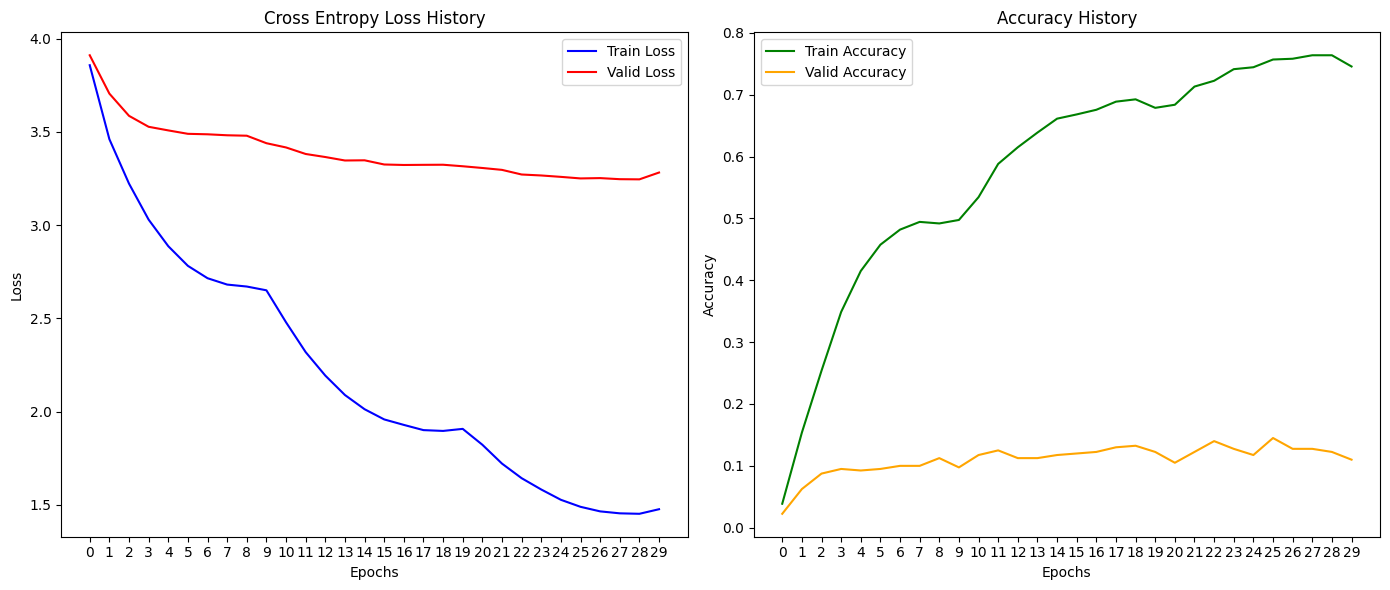

In [33]:
loss_hist_plot(tr_loss_hist, vl_loss_hist, tr_acc_hist, vl_acc_hist)

Модель сильно переобучивается на тренировочных данных. Волнообразность графиков, кстати, получается благодаря планировщику скорости обучения.

In [35]:
print('Max valid accuracy:', max(vl_acc_hist))

Max valid accuracy: 0.145


Модель выдает 14,5 % точности на валидационной выборке. Это лучше, чем 2 %, на которые мы могли бы рассчитывать, если бы просто рандомно выбирали один из 50 классов. Но, вероятно, результат можно улучшить, если попробовать решить эту задачу не напрямую через данные о звуках.

## Мел-спектрограммы

Традиционно, чтобы попасть в диапазон частот, к звуковому сигналу необходимо применить преобразование Фурье. Мы пойдем немного дальше, создав спектрограммы в мел-шкале. Мел-шкала определяет шкалу высот звука, равноудаленных друг от друга, где 1000 мел = 1000 Гц. Эта шкала обычно используется при обработке аудиоданных, особенно для распознавания и классификации речи. Для создания мел-спектрограммы с помощью LibROSA можно обойтись двумя строчками кода:

random wav file name: 2-117615-B-48.wav
object class: fireworks


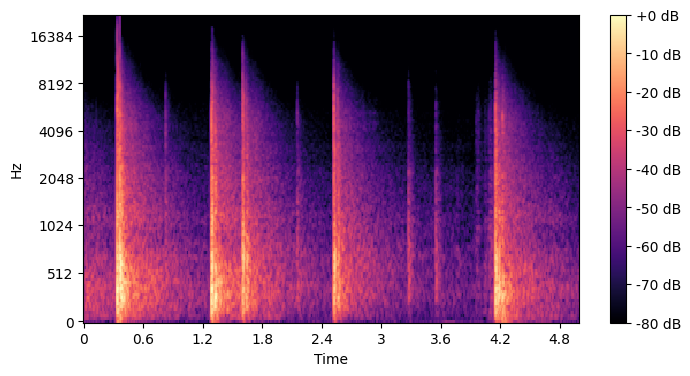

In [19]:
# Выбираем случайный файл
random_wav_file_name = random.choice(os.listdir('/kaggle/working/train'))
# Две строчки кода:
sample_data, sr = librosa.load("/kaggle/working/train/" + random_wav_file_name, sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
# Визуализация логарифмической мел-спектрограммы
print('random wav file name:', random_wav_file_name)
print('object class:',
    lbl2cat[int(random_wav_file_name.split('.')[0].split('-')[-1])]
)
fig, ax = plt.subplots(figsize=(8, 4), sharex=True)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
img = librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
fig.colorbar(img, format="%+2.f dB");

Мы теперь можем создавать представления изображений нашего аудио и использовать предварительно обученную сеть, чтобы значительно улучшить точность при небольшом обучении, используя перенос обучения.

## Новый набор данных

In [20]:
# Функция для получения изображений спектрограмм
def precompute_spectrograms(path, dpi=50):
    files = os.listdir(path)
    for _, filename in enumerate(tqdm(files)):
        audio_tensor, sample_rate = librosa.load(path + '/' + filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sample_rate)
        plt.gcf().savefig("{}.png".format(filename), dpi=dpi)


# Новый класс датасета 
class PrecomputedESC50(Dataset):
    def __init__(self, path, dpi=50, transforms=None):
        files = Path(path).glob('*.wav.png')
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if transforms == None:
            self.transforms = transforms.Compose(
                [transforms.ToTensor()]
            )
        else:
            self.transforms = transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.transforms(img), label)
            
    def __len__(self):
        return self.length

Далее наша стретегия следующая: мы оставим на несколко часов алгоритм преобразовывать аудиоданные в изображения спектрограмм. Я не стал бы делать этого с подключенным GPU, т.к. это истратило бы впустую изрядную часть квоты на kaggle.

Также [оригинальная функция](https://github.com/falloutdurham/pytorchupandrunning/blob/master/chapter6/Chapter%206.ipynb) вообще не очень оптимальная, т.к. не предусматривает распараллеливания процесса обработки и не лучшим образом работает с памятью.

Если вы не собираетесь тратить время на поиск оптимального решения, то я бы не советовал использовать ни kaggle, ни google colab для преобразования данных, т.к. (1) бесплатные CPU этих платформ могут оказаться слабее чипа на вашем PC (мой случай), (2) из-за длительности процесса может слететь связь с облачным ядром и вся работа пойдет насмарку.

Поэтому я нагрузил CPU своего компа и за 7 часов получил спектрограммы, из результата я создал новый набор данных и закинул его в паблик на kaggle. Скорее всего, я не первый кто так сделал, но мне было лень искать чужое.

In [ ]:
# paths = ['/kaggle/working/train', '/kaggle/working/valid', '/kaggle/working/test']
# for path in paths:
#     precompute_spectrograms(path, dpi=50)

# !zip -r train.zip /kaggle/working/train
# !zip -r valid.zip /kaggle/working/valid
# !zip -r test.zip /kaggle/working/test

In [22]:
!mkdir -p /kaggle/working/train_imgs /kaggle/working/valid_imgs
!mv /kaggle/input/esc-50-spectrograms/ESC-50-spectrograms/1* /kaggle/working/train_imgs/
!mv /kaggle/input/esc-50-spectrograms/ESC-50-spectrograms/2* /kaggle/working/train_imgs/
!mv /kaggle/input/esc-50-spectrograms/ESC-50-spectrograms/3* /kaggle/working/train_imgs/
!mv /kaggle/input/esc-50-spectrograms/ESC-50-spectrograms/4* /kaggle/working/train_imgs/
!mv /kaggle/input/esc-50-spectrograms/ESC-50-spectrograms/5* /kaggle/working/valid_imgs/

train_imgs_path = '/kaggle/working/train_imgs/'
valid_imgs_path = '/kaggle/working/valid_imgs/'

## Предобученный ResNet50

In [23]:
# Датасеты
esc50pre_train = PrecomputedESC50(
    train_imgs_path,
    transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]))

esc50pre_valid = PrecomputedESC50(
    valid_imgs_path,
    transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]))  

# Загрузчики
esc50_train_loader = DataLoader(
    dataset=esc50pre_train,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
    )

esc50_val_loader  = DataLoader(
    dataset=esc50pre_valid,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
    )

In [32]:
# Загрузка предобученной модели
spec_resnet = models.resnet50(weights='IMAGENET1K_V2')

# Замарозка весов
for param in spec_resnet.parameters():
    param.requires_grad = False

# Замена классификатора
spec_resnet.fc = nn.Sequential(
    nn.Linear(spec_resnet.fc.in_features,500),
    nn.ReLU(), 
    nn.Dropout(), nn.Linear(500,50)
)

spec_resnet.to(device);

In [34]:
learning_rate = 1e-4
optimizer = optim.Adam(spec_resnet.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
criterion = nn.CrossEntropyLoss()

In [35]:
# Обучение классификатора
rn_tr_loss_hist1, rn_vl_loss_hist1, rn_tr_acc_hist1, rn_vl_acc_hist1 = train(
    spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=5, rep_freq=None
)

Training: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


===> Epoch 1 Complete: Avg. Loss: 3.8990
===> Avg. Accuracy: 0.0288


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


===> Avg. Loss: 3.8728
===> Avg. Accuracy: 0.0575


Training: 100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


===> Epoch 2 Complete: Avg. Loss: 3.8356
===> Avg. Accuracy: 0.0894


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


===> Avg. Loss: 3.8226
===> Avg. Accuracy: 0.1325


Training: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


===> Epoch 3 Complete: Avg. Loss: 3.7769
===> Avg. Accuracy: 0.1487


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


===> Avg. Loss: 3.7744
===> Avg. Accuracy: 0.1400


Training: 100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


===> Epoch 4 Complete: Avg. Loss: 3.7190
===> Avg. Accuracy: 0.1900


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]


===> Avg. Loss: 3.7296
===> Avg. Accuracy: 0.2625


Training: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


===> Epoch 5 Complete: Avg. Loss: 3.6659
===> Avg. Accuracy: 0.2294


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


===> Avg. Loss: 3.6950
===> Avg. Accuracy: 0.2850


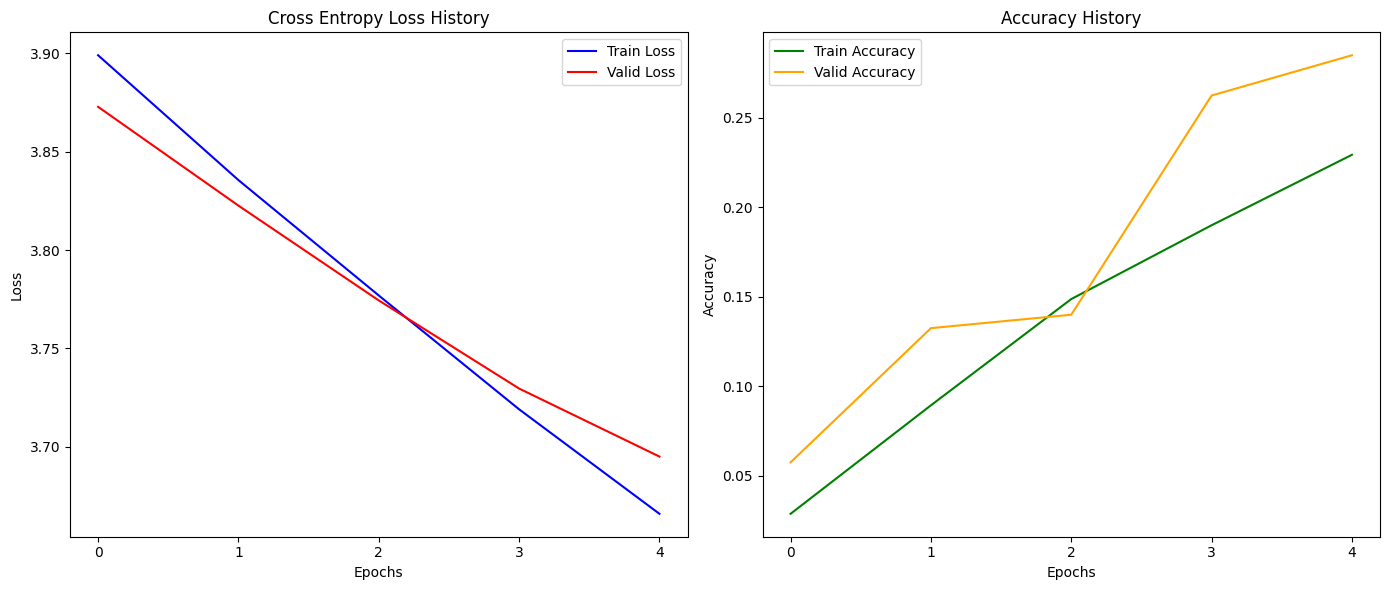

In [36]:
loss_hist_plot(rn_tr_loss_hist1, rn_vl_loss_hist1, rn_tr_acc_hist1, rn_vl_acc_hist1)

Отлично, loss-ы и точности ведут себя согласованно.

In [37]:
# Разморозка весов resnet
for param in spec_resnet.parameters():
    param.requires_grad = True

# Обучение всей сети
rn_tr_loss_hist2, rn_vl_loss_hist2, rn_tr_acc_hist2, rn_vl_acc_hist2 = train(
    spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=20, rep_freq=None
)

Training: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


===> Epoch 1 Complete: Avg. Loss: 3.1796
===> Avg. Accuracy: 0.2981


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


===> Avg. Loss: 2.5139
===> Avg. Accuracy: 0.4475


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 2 Complete: Avg. Loss: 2.0381
===> Avg. Accuracy: 0.5100


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


===> Avg. Loss: 1.6496
===> Avg. Accuracy: 0.5875


Training: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


===> Epoch 3 Complete: Avg. Loss: 1.1881
===> Avg. Accuracy: 0.7200


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


===> Avg. Loss: 1.2271
===> Avg. Accuracy: 0.6525


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 4 Complete: Avg. Loss: 0.6725
===> Avg. Accuracy: 0.8544


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


===> Avg. Loss: 1.0046
===> Avg. Accuracy: 0.6975


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 5 Complete: Avg. Loss: 0.4229
===> Avg. Accuracy: 0.9206


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


===> Avg. Loss: 0.9130
===> Avg. Accuracy: 0.7475


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 6 Complete: Avg. Loss: 0.2978
===> Avg. Accuracy: 0.9494


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


===> Avg. Loss: 0.8609
===> Avg. Accuracy: 0.7525


Training: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


===> Epoch 7 Complete: Avg. Loss: 0.2305
===> Avg. Accuracy: 0.9681


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


===> Avg. Loss: 0.8354
===> Avg. Accuracy: 0.7700


Training: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


===> Epoch 8 Complete: Avg. Loss: 0.1987
===> Avg. Accuracy: 0.9769


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


===> Avg. Loss: 0.8348
===> Avg. Accuracy: 0.7650


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 9 Complete: Avg. Loss: 0.1993
===> Avg. Accuracy: 0.9719


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


===> Avg. Loss: 0.8277
===> Avg. Accuracy: 0.7650


Training: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


===> Epoch 10 Complete: Avg. Loss: 0.1856
===> Avg. Accuracy: 0.9669


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


===> Avg. Loss: 0.9015
===> Avg. Accuracy: 0.7275


Training: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


===> Epoch 11 Complete: Avg. Loss: 0.1067
===> Avg. Accuracy: 0.9869


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


===> Avg. Loss: 0.8637
===> Avg. Accuracy: 0.7600


Training: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


===> Epoch 12 Complete: Avg. Loss: 0.0669
===> Avg. Accuracy: 0.9938


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


===> Avg. Loss: 0.8049
===> Avg. Accuracy: 0.7425


Training: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


===> Epoch 13 Complete: Avg. Loss: 0.0470
===> Avg. Accuracy: 0.9962


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


===> Avg. Loss: 0.7584
===> Avg. Accuracy: 0.7775


Training: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


===> Epoch 14 Complete: Avg. Loss: 0.0285
===> Avg. Accuracy: 0.9981


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


===> Avg. Loss: 0.7246
===> Avg. Accuracy: 0.7975


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 15 Complete: Avg. Loss: 0.0179
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


===> Avg. Loss: 0.7200
===> Avg. Accuracy: 0.7875


Training: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


===> Epoch 16 Complete: Avg. Loss: 0.0148
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


===> Avg. Loss: 0.7164
===> Avg. Accuracy: 0.7925


Training: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


===> Epoch 17 Complete: Avg. Loss: 0.0135
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


===> Avg. Loss: 0.7268
===> Avg. Accuracy: 0.7825


Training: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


===> Epoch 18 Complete: Avg. Loss: 0.0122
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


===> Avg. Loss: 0.7141
===> Avg. Accuracy: 0.7950


Training: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


===> Epoch 19 Complete: Avg. Loss: 0.0120
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


===> Avg. Loss: 0.7160
===> Avg. Accuracy: 0.8000


Training: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


===> Epoch 20 Complete: Avg. Loss: 0.0151
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


===> Avg. Loss: 0.7406
===> Avg. Accuracy: 0.7925


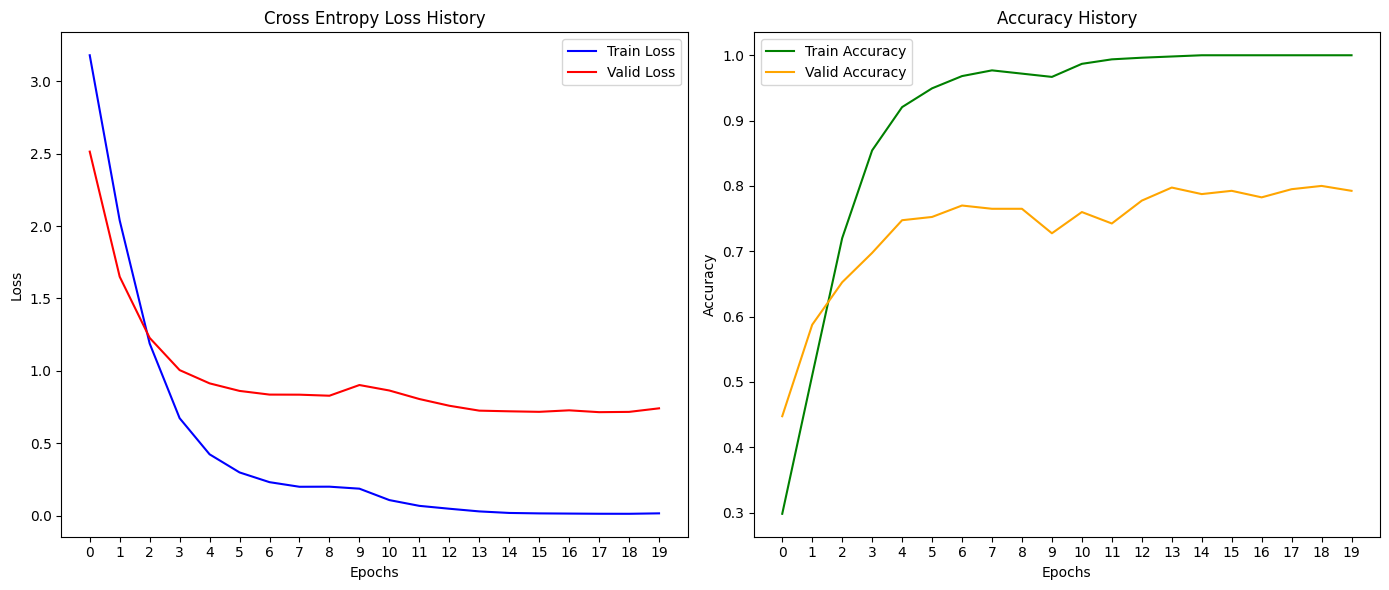

In [38]:
loss_hist_plot(rn_tr_loss_hist2, rn_vl_loss_hist2, rn_tr_acc_hist2, rn_vl_acc_hist2)

In [39]:
print('Max valid accuracy:', max(rn_vl_acc_hist2))

Max valid accuracy: 0.8


## Аугментация данных

In [ ]:
class ESC50WithPitchChange(Dataset):

    def __init__(self, path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(f,f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
        self.E = torchaudio.sox_effects.SoxEffectsChain()
        self.E.append_effect_to_chain("pitch", [0.5])
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        self.E.set_input_file(filename)
        audio_tensor, sample_rate = self.E.sox_build_flow_effects()
        return audio_tensor, label
        
    def __len__(self):
        return self.length

In [ ]:
class FrequencyMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the frequency 
            mask is to be applied.

        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
        start = random.randrange(0, tensor.shape[2])
        end = start + random.randrange(1, self.max_width)
        if self.use_mean:
            tensor[:, start:end, :] = tensor.mean()
        else:
            tensor[:, start:end, :] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')

        return format_string

In [ ]:
torchvision.transforms.Compose([FrequencyMask(max_width=10, use_mean=False),
torchvision.transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class TimeMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     TimeMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the time mask 
            is to be applied.

        Returns:
            Tensor: Transformed image with Time Mask.
        """
        start = random.randrange(0, tensor.shape[1])
        end = start + random.randrange(0, self.max_width)
        if self.use_mean:
            tensor[:, :, start:end] = tensor.mean()
        else:
            tensor[:, :, start:end] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')
        return format_string

In [ ]:
torchvision.transforms.Compose([TimeMask(max_width=10, use_mean=False),
torchvision.transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class PrecomputedTransformESC50(Dataset):
    def __init__(self,path,dpi=50):
        files = Path(path).glob('{}*.wav.png'.format(dpi))
        self.items = [(f,f.name.split("-")[-1].replace(".wav.png","")) for f in files]
        self.length = len(self.items)
        self.transforms = transforms.Compose([
    transforms.ToTensor(),
    RandomApply([FrequencyMask(self.max_freqmask_width)]p=0.5),
    RandomApply([TimeMask(self.max_timemask_width)]p=0.5)
])
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename)
        return (self.transforms(img), label)
        
    def __len__(self):
        return self.length